In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from time import perf_counter
import cv2 as cv
import pandas as pd
import pathlib
import psutil
from tensorflow.keras.preprocessing import image

In [ ]:
tf.__version__

'2.9.2'

In [ ]:
classes = ['0_Healthy', '1_Unhealthy']

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
IMG_SHAPE = 224
BATCH_SIZE = 32

In [ ]:
dataset_dir = "/content/gdrive/MyDrive/iot/data"
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'validation')
train_data = tf.keras.utils.image_dataset_from_directory(train_dir, 
                                                         labels = "inferred", 
                                                         color_mode='rgb', 
                                                         batch_size=BATCH_SIZE, 
                                                         image_size=(IMG_SHAPE, IMG_SHAPE))

val_data = tf.keras.utils.image_dataset_from_directory(val_dir, 
                                                       labels = "inferred", 
                                                       color_mode='rgb', 
                                                       batch_size=BATCH_SIZE,
                                                       image_size=(IMG_SHAPE, IMG_SHAPE))

Found 6010 files belonging to 2 classes.
Found 933 files belonging to 2 classes.


In [ ]:
num_classes = len(train_data.class_names)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_SHAPE, IMG_SHAPE),
  tf.keras.layers.Rescaling(1./255)
])

# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip("horizontal_and_vertical"),
#   tf.keras.layers.RandomRotation(0.2),
# ])

In [ ]:
import tensorflow_hub as hub
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = inception_v3

In [ ]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(IMG_SHAPE, IMG_SHAPE, 3),
    trainable=False)

In [ ]:
# for image_batch, labels_batch in train_data:
#   feature_batch = feature_extractor_layer(image_batch)
#   print(feature_batch.shape)
#   break

(32, 2048)


In [ ]:
model = tf.keras.Sequential([
    resize_and_rescale,
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes, activation = 'softmax')
]) 

model.build(input_shape=(None, IMG_SHAPE, IMG_SHAPE, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
# for image_batch, labels_batch in train_data:
#   predictions = model(image_batch)
#   break

In [ ]:
# predicted_labels = np.argmax(np.array(predictions), axis = 1)
# orig_labels = np.array(labels_batch)
# accuracy = np.average(predicted_labels == orig_labels)
# print(accuracy)

0.53125


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=['acc'])

In [ ]:
NUM_EPOCHS = 20

history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=NUM_EPOCHS)

Epoch 1/20
188/188 [==============================] - 1372s 7s/step - loss: 0.4296 - acc: 0.7990 - val_loss: 0.3537 - val_acc: 0.8349
Epoch 2/20
188/188 [==============================] - 110s 564ms/step - loss: 0.2762 - acc: 0.8890 - val_loss: 0.2947 - val_acc: 0.8746
Epoch 3/20
188/188 [==============================] - 112s 575ms/step - loss: 0.2411 - acc: 0.9007 - val_loss: 0.2915 - val_acc: 0.8778
Epoch 4/20
188/188 [==============================] - 111s 569ms/step - loss: 0.2179 - acc: 0.9113 - val_loss: 0.2763 - val_acc: 0.8821
Epoch 5/20
188/188 [==============================] - 113s 582ms/step - loss: 0.2116 - acc: 0.9133 - val_loss: 0.2682 - val_acc: 0.8960
Epoch 6/20
188/188 [==============================] - 111s 569ms/step - loss: 0.1959 - acc: 0.9210 - val_loss: 0.2761 - val_acc: 0.8864
Epoch 7/20
188/188 [==============================] - 113s 580ms/step - loss: 0.1842 - acc: 0.9311 - val_loss: 0.2405 - val_acc: 0.9068
Epoch 8/20
188/188 [==============================

In [ ]:
def plot_history(hist,Text):
  history=hist
  acc = history.history["acc"]
  val_acc = history.history["val_acc"]

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  epochs_range = range(len(history.epoch))

  plt.figure(figsize=(10,10))
  plt.subplot(1,2,1)
  plt.plot(epochs_range,acc,label="Train Accuracy")
  plt.plot(epochs_range,val_acc,label="Validation Accuracy")
  plt.legend(loc = 'lower right')
  plt.title("Accuracy")
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label="Train Loss")
  plt.plot(epochs_range,val_loss,label="Validation Loss")
  plt.legend(loc = 'upper right')
  plt.title("Loss")
  plt.suptitle(Text)

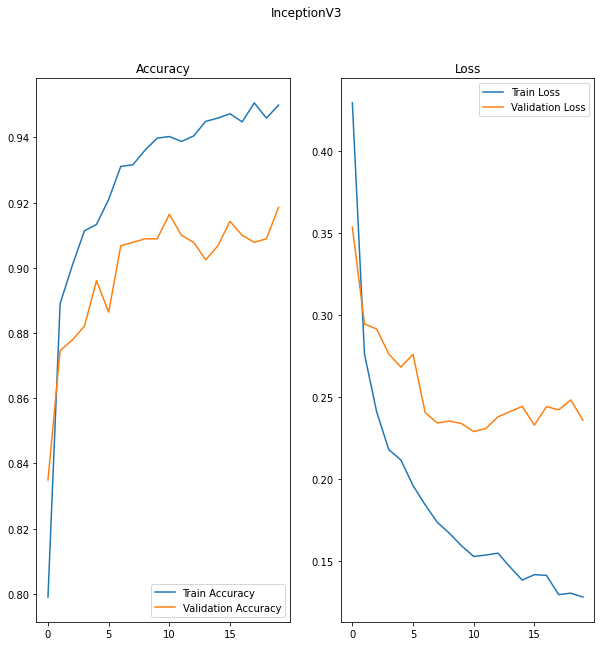

In [ ]:
plot_history(history,"InceptionV3")

In [ ]:
model.save('/content/gdrive/MyDrive/iot_second/coffee1')

In [ ]:
loaded_model = tf.keras.models.load_model('/content/gdrive/MyDrive/iot_second/coffee1')
loaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/gdrive/MyDrive/iot_second/coffee1')
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)
tflite_model_file = pathlib.Path('/content/gdrive/MyDrive/iot_second/coffee1_noquant.tflite')
tflite_model_file.write_bytes(tflite_model)

87166784

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/gdrive/MyDrive/iot_second/coffee1')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)
tflite_model_file = pathlib.Path('/content/gdrive/MyDrive/iot_second/coffee1_dyn_quant.tflite')
tflite_model_file.write_bytes(tflite_model)

22112184

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/gdrive/MyDrive/iot_second/coffee1')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)
tflite_model_file = pathlib.Path('/content/gdrive/MyDrive/iot_second/coffee1_f16_quant.tflite')
tflite_model_file.write_bytes(tflite_model)

43654752